In [1]:
# Loading Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k,auc_score,reciprocal_rank
import scipy
import time
import math
from lightfm.data import Dataset
import warnings
warnings.filterwarnings('ignore')

C:\Users\shouv\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
# Loading DataSets

users = pd.read_csv('users_tag.csv',index_col=0)
business = pd.read_csv('business_cj.csv',index_col=0)
review = pd.read_csv('IL_review.csv',index_col=0)
food_inspections_dataset = pd.read_csv('Food_Inspections.csv',index_col=0)
data = pd.read_csv('dc_dec_2019_sf3_u_data1.csv',index_col=0)


In [3]:
# Mapping the secondary dataset

business = pd.merge(business, food_inspections_dataset[['DBA Name', 'Risk','Zip']], left_on = ['name','postal_code'],right_on = ['DBA Name','Zip'], how = 'left')
business = pd.merge(business, data[['ZIPCODE', 'Median_income_2019']], left_on = ['postal_code'],right_on = ['ZIPCODE'], how = 'left')
business=business.drop(columns =['DBA Name','ZIPCODE','Zip'])

## Check Sparsity

In [4]:
#For recommender system you want to see which user bought which item or which user rated which item.
#In practical scenario users do not rate/ buy every item, large number of users are concentrated on few items 
# and hence a certain amount of items are untouched by users.

# Since we do not have any action of customers on some items while we have it on certain other items, 
# this emptiness of interaction is called sparsity problem.



n_users = review.user_id.unique().shape[0]
n_items = review.business_id.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(review.shape[0]) / float(n_users*n_items) * 100))

Number of users: 12859
Number of models: 845
Sparsity: 0.326%


(array([1.2649e+04, 1.5400e+02, 3.3000e+01, 1.0000e+01, 7.0000e+00,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 4.8370e+02, 9.6640e+02, 1.4491e+03, 1.9318e+03,
        2.4145e+03, 2.8972e+03, 3.3799e+03, 3.8626e+03, 4.3453e+03,
        4.8280e+03]),
 <a list of 10 Patch objects>)

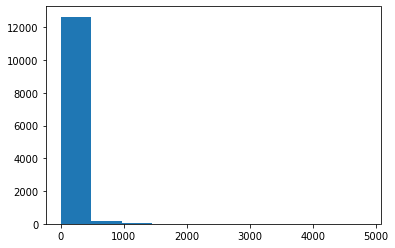

In [5]:
# looking at the review distribution

plt.hist(users.review_count)


(array([  5.,  39., 104., 101.,   0., 194., 210., 175., 101.,  24.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

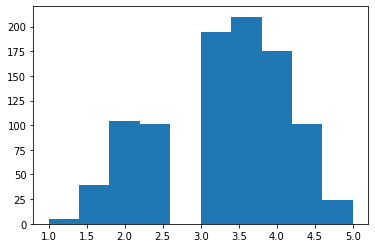

In [6]:
# looking at the stars distribution

plt.hist(business.stars)

(array([424., 135.,   0.,  54.,  38.,   6., 151.,  22.,  44.,  79.]),
 array([19591. , 23666.8, 27742.6, 31818.4, 35894.2, 39970. , 44045.8,
        48121.6, 52197.4, 56273.2, 60349. ]),
 <a list of 10 Patch objects>)

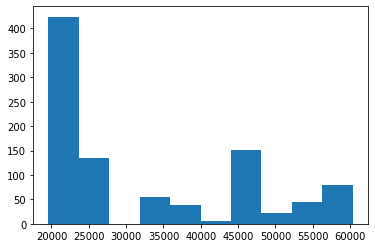

In [7]:
# looking at the median Income distribution

plt.hist(business.Median_income_2019)

(array([3.4645e+04, 6.1900e+02, 8.1000e+01, 2.5000e+01, 5.0000e+00,
        8.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  2.8,  5.6,  8.4, 11.2, 14. , 16.8, 19.6, 22.4, 25.2, 28. ]),
 <a list of 10 Patch objects>)

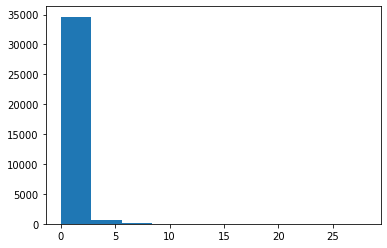

In [8]:
# looking at the cool distribution

plt.hist(review.cool)

(array([3.2996e+04, 1.9670e+03, 3.0200e+02, 8.0000e+01, 1.1000e+01,
        2.1000e+01, 5.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ]),
 <a list of 10 Patch objects>)

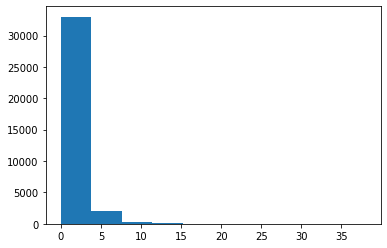

In [9]:
# looking at the useful distribution

plt.hist(review.useful)

(array([3.5082e+04, 2.3600e+02, 4.1000e+01, 1.9000e+01, 7.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

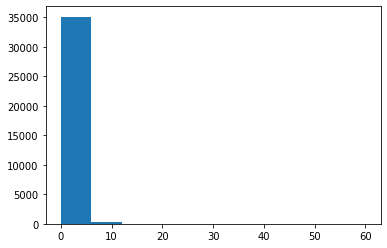

In [10]:
# looking at the funny distribution

plt.hist(review.funny)

In [11]:
# clean user skewness
users.review_count = pd.Series([math.log(x+1) for x in users.review_count])
users.useful =  pd.Series([math.log(x+1) for x in users.useful])
users.cool =  pd.Series([math.log(x+1) for x in users.cool])
users.funny =  pd.Series([math.log(x+1) for x in users.funny])

#cleam business skewness
business.review_count =  pd.Series([math.log(x+1) for x in business.review_count])

In [12]:
# checking if there are duplicate reviews
a = review.groupby(['business_id','user_id']).agg(['count']).reset_index()
tmp = a.useful.sort_values(by = 'count',ascending = False).reset_index()
tmp[tmp['count'] >1].shape

(1081, 2)

### 1081 users have multiple review for one business 

In [13]:
multiple_reviewers = tmp[tmp['count']>1]['index']
multiple_reviewers

0       26917
1        5843
2        5233
3       22282
4          69
        ...  
1076    16741
1077     5210
1078    17853
1079     5204
1080    27569
Name: index, Length: 1081, dtype: int64

In [14]:
# removing duplicate entries and taking latest entries of users for a particular business

for ind in multiple_reviewers:
    tmp = review[(review.user_id == a.loc[ind, 'user_id'][0]) & 
                 (review.business_id == a.loc[ind, 'business_id'][0])].sort_values(by = 'date', ascending = True)
    review.drop(tmp.index[0:len(tmp.index)-1],inplace=True)

In [15]:
# checking if duplicate values have been removed

b = review.groupby(['business_id','user_id']).agg(['count']).reset_index()
tmp = b.useful.sort_values(by = 'count',ascending = False).reset_index()
tmp[tmp['count'] >1].shape

(0, 2)

In [16]:
# the review_stars contains bias, thus needs to be normalized by subtracting the average stars from it and 
# make negative stars to -1 and positive stars to +1

user_ind = review.user_id.unique()
for ind in user_ind:
    this_avg=users.average_stars[users.user_id == ind]
    temp = review.stars[review.user_id == ind] - float(this_avg)
    temp[temp>0] = 1
    temp[temp<0] = -1
    review.stars[review.user_id == ind] = temp


In [17]:
review.stars.unique()

array([-1.,  1.,  0.])

In [18]:
# The first thing we need to do is to create a mapping between the user id and business ids from our input data 
# This mapping will provide indices that will be used internally by our model.

# model establishment
dataset = Dataset()
dataset.fit(review.user_id,review.business_id)
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 12859, num_items 845.


In [19]:
# fit item and user features.

dataset.fit_partial(items=business.business_id,
                    item_features=['stars'])
dataset.fit_partial(items=business.business_id,
                    item_features=['review_count'])
dataset.fit_partial(items=business.business_id,
                    item_features=['Median_income_2019'])


In [20]:
business.category 

0      Ethnic Food, Food Trucks, Specialty Food, Impo...
1      Restaurants, Diners, Sandwiches, Breakfast & B...
2      Restaurants, Diners, Sandwiches, Breakfast & B...
3                        Hot Dogs, Restaurants, Barbeque
4                             Donuts, Food, Coffee & Tea
                             ...                        
948            Sushi Bars, Chinese, Buffets, Restaurants
949      Fast Food, Restaurants, Tex-Mex, Mexican, Tacos
950                                 Italian, Restaurants
951                 Fast Food, Restaurants, Pizza, Salad
952                   Sandwiches, Fast Food, Restaurants
Name: category, Length: 953, dtype: object

In [21]:
# We have categories from column number 45

tar_cols = [x for x in business.columns[45:106]]

dataset.fit_partial(items = business.business_id,
                   item_features = tar_cols) 

In [22]:
# Creating useful features from the users dataset

user_cols = [x for x in users.drop(columns = ['user_id', 'name', 'yelping_since', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'year',]).columns]

In [23]:
# Adding User Features

dataset.fit_partial(users = users.user_id,
                    user_features = user_cols)

In [24]:
# Check data

print(type(dataset))
print(dataset.model_dimensions())
print(dataset.user_features_shape())
print(dataset.item_features_shape())
print(dataset.interactions_shape())

<class 'lightfm.data.Dataset'>
(12909, 910)
(12859, 12909)
(846, 910)
(12859, 846)


In [25]:
# look at item feature mapping
a = dataset.mapping()[3]
list(a.items())[0:10]

[('9A1C1f0m4nQltQrOOTl-Kw', 0),
 ('VHsNB3pdGVcRgs6C3jt6Zg', 1),
 ('Ah4i15g8Ow_zphzcpulTxQ', 2),
 ('9MnbQg7kfb_WgxoV0hXKSQ', 3),
 ('t_yiQnxUDdPPCN2z4QyezA', 4),
 ('-fiUXzkxRfbHY9TKWwuptw', 5),
 ('NEVA0IYbawceL6kz5v5DAw', 6),
 ('RwMlwusAtxZc5a3ZYduulg', 7),
 ('ObNQVg_ohRVLex4ppmMC5w', 8),
 ('-Jhlh8Scjy669NdtCfKSSg', 9)]

In [26]:
#build interaction

(interactions, weights) = dataset.build_interactions([(x['user_id'], x['business_id'], 
                                                       x['stars']) for index,x in review.iterrows()])
print(repr(interactions))

<12859x846 sparse matrix of type '<class 'numpy.int32'>'
	with 34223 stored elements in COOrdinate format>


In [27]:
def build_dict(df,tar_cols,val_list):
    rst = {}
    for col in tar_cols:
        rst[col] = df[col]
    sum_val = sum(list(rst.values())) # get sum of all the tfidf values
    
    if(sum_val == 0):
        return rst
    else:
        
        w = (2-sum(val_list))/sum_val # weight for each tag to be able to sum to 1
        for key,value in rst.items():
            rst[key] = value * w
    return rst

# get max of each column to regularize value to [0,1]
max_star = max(business.stars)
max_b_review_count = max(business.review_count)
max_Median_income_2019= max(business.Median_income_2019)
business['Median_income_2019']=pd.to_numeric(business['Median_income_2019'])
print('maximum business review count')
print(max_b_review_count)

# give CF info weight 0.5, all other 0.5. Then in others, give (star, review count) 0.25 and tags 0.25
item_features = dataset.build_item_features([(x['business_id'], 
                                              {'stars':0.5*x['stars']/max_star,'review_count':0.5*x['Median_income_2019']/max_Median_income_2019,
                                               'review_count':0.5*x['review_count']/max_b_review_count,
                                               **build_dict(x,tar_cols,[0.5*x['stars']/max_star,
                                                           0.5*x['review_count']/max_b_review_count,0.5*x['Median_income_2019']/max_Median_income_2019])})
                                              for index,x in business.iterrows()])

max_u_review_count = max(users.review_count)
max_useful = max(users.useful)
print('maximum user review count')
print(max_u_review_count)
print('Median income 2019')
print(max_Median_income_2019)

user_features = dataset.build_user_features(((x['user_id'],
                                             {'review_count':0.35*x['review_count']/max_u_review_count,'is_elite':0.35*int(x['is_elite']),
                                              'useful':0.35*x['useful']/max_useful,
                                             **build_dict(x,user_cols,[0.35*x['review_count']/max_u_review_count,
                                                                            0.35*int(x['is_elite']),
                                                                            0.35*x['useful']/max_useful])})
                                           for index, x in users.iterrows()))

print(repr(item_features))
print(item_features.shape)

print(repr(user_features))
print(user_features.shape)

maximum business review count
6.723832440821209
maximum user review count
8.482394685873542
Median income 2019
60349.0
<846x910 sparse matrix of type '<class 'numpy.float32'>'
	with 53388 stored elements in Compressed Sparse Row format>
(846, 910)
<12859x12909 sparse matrix of type '<class 'numpy.float32'>'
	with 655809 stored elements in Compressed Sparse Row format>
(12859, 12909)


In [28]:

# check features to see if weights make sense
idx = 3
tt = list(item_features[idx].nonzero())
print(item_features[idx].shape)
print(tt)

uu = list(user_features[idx].nonzero())
print(user_features[idx].shape)
uu

(1, 910)
[array([0, 0, 0, 0, 0, 0, 0, 0]), array([  3, 846, 847, 850, 851, 852, 871, 888])]
(1, 12909)


[array([0, 0, 0, 0]), array([    3, 12859, 12860, 12869])]

In [29]:
# Create a dense structure of item features and user features to view it

tt = item_features[idx].todense()
import pandas as pd
tt = pd.DataFrame(tt)
print(list(map(set,tt.values)))# feature weight sum to 1, so if two are nonzero, each take weight 0.5. 

uu = user_features[idx].todense()
uu = pd.DataFrame(uu)
list(map(set,uu.values))# feature weight sum to 1, so if two are nonzero, each take weight 0.5.

[{0.0, 0.35926408, 0.05988701, 0.16166884, 0.17963204}]


[{0.0, 0.114341676, 0.23776683, 0.29328063, 0.35461086}]

In [30]:
tt

,0,1,2,3,4,5,6,7,8,9,...,900,901,902,903,904,905,906,907,908,909
0,0.0,0.0,0.0,0.359264,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
uu


,0,1,2,3,4,5,6,7,8,9,...,12899,12900,12901,12902,12903,12904,12905,12906,12907,12908
0,0.0,0.0,0.0,0.354611,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#train-test split

seed = 1001
from lightfm.cross_validation import random_train_test_split
train,test=random_train_test_split(interactions,test_percentage=0.2,random_state=np.random.RandomState(seed))

print('The dataset has %s users and %s items, '
      'with %s interactions in the test and %s interactions in the training set.'
      % (train.shape[0], train.shape[1], test.getnnz(), train.getnnz()))

train.multiply(test).nnz == 0 # make sure train and test are truly disjoint

The dataset has 12859 users and 846 items, with 6845 interactions in the test and 27378 interactions in the training set.


True

In [33]:

from lightfm import LightFM

# Set the number of threads; you can increase this if you have more physical cores available.

## These parameters are obtained after tunning for specific loss through skopt in the bottom chunk
NUM_THREADS = 25
NUM_COMPONENTS = 43    
NUM_EPOCHS =40
ITEM_ALPHA = 2.88752e-6
learning_rate=0.06652
k = 5 # for precision at k

## Pure Collaborative Filtering models

# Logistic loss
model_1 = LightFM(loss='logistic',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

# time it.
%time model_1 = model_1.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)


# Import the evaluation routines
from lightfm.evaluation import auc_score

# Compute and print the AUC score
train_auc = auc_score(model_1, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model_1, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

from lightfm.evaluation import precision_at_k,recall_at_k

print("Train precision: %.4f" % precision_at_k(model_1, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model_1, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())

Wall time: 19.7 s
Collaborative filtering train AUC: 0.8156379
Collaborative filtering test AUC: 0.8056547
Train precision: 0.0429
Test precision: 0.0319


In [267]:

NUM_THREADS = 25
NUM_COMPONENTS = 45    
NUM_EPOCHS = 43
ITEM_ALPHA = 1.3846e-6
learning_rate=0.0161445

# BPR loss
model = LightFM(loss='bpr',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

# time it.
%time model = model.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)


# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

print("Train precision: %.4f" % precision_at_k(model, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())

Wall time: 11.4 s
Collaborative filtering train AUC: 0.86342514
Collaborative filtering test AUC: 0.5687692
Train precision: 0.1494
Test precision: 0.0168


# Here we can see that the loss function bpr is showing serious overfitting with drop in accuracy of the train and test

In [268]:
NUM_THREADS = 25
NUM_COMPONENTS = 21    
NUM_EPOCHS = 16
ITEM_ALPHA = 5.97967e-6
learning_rate=0.033

# Let's fit a WARP model
model = LightFM(loss='warp',random_state=seed,
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS,
               learning_rate=learning_rate)

#  time it.
%time model = model.fit(train,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)



# Compute and print the AUC score
train_auc = auc_score(model, train, num_threads=NUM_THREADS).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

test_auc = auc_score(model, test,num_threads=NUM_THREADS).mean()
print('Collaborative filtering test AUC: %s' % test_auc)


print("Train precision: %.4f" % precision_at_k(model, train, k=k,num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model, test,train_interactions=train, k=k,num_threads=NUM_THREADS).mean())

Wall time: 1.69 s
Collaborative filtering train AUC: 0.96849805
Collaborative filtering test AUC: 0.8007936
Train precision: 0.2039
Test precision: 0.0311


In [269]:
NUM_THREADS = 25
NUM_COMPONENTS = 30
learning_rate = 0.0053
NUM_EPOCHS = 6
ITEM_ALPHA = 2.228e-5

## Hybrid models

#Combine user_feature and item feature

#logistic loss
model.iii = LightFM(loss='logistic',
                item_alpha=ITEM_ALPHA,
                    random_state=seed,
               no_components=NUM_COMPONENTS,learning_rate=learning_rate)

# time it.
%time model.iii = model.iii.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)

# Compute and print the AUC score
train_auc = auc_score(model.iii, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print(' Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model.iii, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)

#precision @k
print("Train precision: %.4f" % precision_at_k(model.iii, train,
                                               item_features=item_features,user_features=user_features, k=k,
                                               num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model.iii, test,train_interactions=train,
                                              item_features=item_features,user_features=user_features, k=k,
                                             num_threads=NUM_THREADS).mean())


Wall time: 9.72 s
 Hybrid train AUC: 0.70179355
Hybrid test AUC: 0.6982656
Train precision: 0.0076
Test precision: 0.0056


In [270]:
NUM_THREADS = 25
NUM_COMPONENTS = 77    
NUM_EPOCHS = 80
ITEM_ALPHA = 1.419e-6
learning_rate=0.035


# BPR
model.iii = LightFM(loss='bpr',
                item_alpha=ITEM_ALPHA,
                     random_state=seed,
               no_components=NUM_COMPONENTS,learning_rate=learning_rate)

#  time it.
%time model.iii = model.iii.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)


# Compute and print the AUC score
train_auc = auc_score(model.iii, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print('Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model.iii, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)

#precision @k
print("Train precision: %.4f" % precision_at_k(model.iii, train,
                                               item_features=item_features,user_features=user_features, k=k,
                                              num_threads=NUM_THREADS).mean())#0.41
print("Test precision: %.4f" % precision_at_k(model.iii, test,train_interactions=train,
                                              item_features=item_features,user_features=user_features, k=k,
                                             num_threads=NUM_THREADS).mean())#0.17


Wall time: 8min 25s
Hybrid train AUC: 0.9362968
Hybrid test AUC: 0.80821425
Train precision: 0.0559
Test precision: 0.0268


In [271]:
NUM_THREADS = 50
NUM_COMPONENTS = 42    
NUM_EPOCHS = 30
ITEM_ALPHA = 0.000256
learning_rate=0.0529
# WARP
model.iii = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA, random_state=seed,
               no_components=NUM_COMPONENTS,learning_rate=learning_rate,learning_schedule='adagrad')

#time it.
%time model.iii = model.iii.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)



# Compute and print the AUC score
train_auc = auc_score(model.iii, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print('Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model.iii, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)

#precision @k
print("Train precision: %.4f" % precision_at_k(model.iii, train,
                                               item_features=item_features,user_features=user_features, k=k,
                                              num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model.iii, test,train_interactions=train,
                                              item_features=item_features,user_features=user_features, k=k,
                                             num_threads=NUM_THREADS).mean())

Wall time: 1min 28s
Hybrid train AUC: 0.95442474
Hybrid test AUC: 0.88656795
Train precision: 0.0961
Test precision: 0.0568


In [36]:
NUM_THREADS = 50
NUM_COMPONENTS = 42    
NUM_EPOCHS = 30
ITEM_ALPHA = 0.000256
learning_rate=0.0529
# WARP
model_opt = LightFM(loss='warp-kos',
                item_alpha=ITEM_ALPHA, random_state=seed,
               no_components=NUM_COMPONENTS,learning_rate=learning_rate,learning_schedule='adagrad')

#time it.
%time model_opt = model_opt.fit(train,user_features=user_features,item_features=item_features,epochs=NUM_EPOCHS,num_threads=NUM_THREADS)



# Compute and print the AUC score
train_auc = auc_score(model_opt, train,user_features=user_features,item_features=item_features, num_threads=NUM_THREADS).mean()
print('Hybrid train AUC: %s' % train_auc)

test_auc = auc_score(model_opt, test,user_features=user_features,item_features=item_features,num_threads=NUM_THREADS).mean()
print('Hybrid test AUC: %s' % test_auc)

#precision @k
print("Train precision: %.4f" % precision_at_k(model_opt, train,
                                               item_features=item_features,user_features=user_features, k=k,
                                              num_threads=NUM_THREADS).mean())
print("Test precision: %.4f" % precision_at_k(model_opt, test,train_interactions=train,
                                              item_features=item_features,user_features=user_features, k=k,
                                             num_threads=NUM_THREADS).mean())

Wall time: 3min 34s
Hybrid train AUC: 0.96315956
Hybrid test AUC: 0.8841477
Train precision: 0.0995
Test precision: 0.0570


In [37]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
def sample_train_recommendation(model, train, data_meta, user_ids, k, name, mapping, tag=None, user_features=None,
                                item_features=None, num_threads=50):
    n_users, n_items = train.shape

    # =============================================================================
    #     ranks = model.predict_rank(interactions,
    #                                train_interactions=train_interactions,
    #                                user_features=user_features,
    #                                item_features=item_features,
    #                                num_threads=num_threads,
    #                                check_intersections=check_intersections,
    #                                )
    #
    #     ranks.data = np.less(ranks.data, k, ranks.data)
    #
    #     precision = np.squeeze(np.array(ranks.sum(axis=1))) / k
    #
    #     if not preserve_rows:
    #         precision = precision[test_interactions.getnnz(axis=1) > 0]
    #
    #     return precision
    # =============================================================================

    for user_id in user_ids:

        t_idx = {value: key for key, value in mapping.items()}
        u_idx = [x for x in train.tocsr()[user_id].indices]
        known_positives = data_meta.loc[u_idx, name]  # may need change
        if tag is not None:
            known_tags = data_meta.loc[u_idx, tag]  # get item tags.

        if (len(known_positives) < k):
            print('not enough known positives, return max number')

        scores = model.predict(user_id, np.arange(n_items), user_features=user_features, item_features=item_features,
                               num_threads=num_threads)
        i_idx = [x for x in np.argsort(-scores)]
        top_items = data_meta.loc[i_idx, name]
        if tag is not None:
            top_tags = data_meta.loc[i_idx, tag]  # get item tags.

        printmd("**User %s**" % user_id)
        printmd("**Known positives:**")

        if tag is not None:
            for x in range(len(known_positives)):
                print(" %s | %s" % (known_positives.values[x], known_tags.values[x]))
        else:
            for x in known_positives[:len(known_positives)]:
                print("        %s" % x)

        printmd("**Recommended:**")
        cnt = 0
        if tag is not None:
            for x in range(k):
                print(" %s | %s" % (top_items.values[x], top_tags.values[x]))
                if (top_items.values[x] in known_positives.values):
                    cnt += 1
                    print('This one clicked')
        else:
            for x in top_items[:k]:
                print("        %s" % x)
                if (x in known_positives.values):
                    cnt += 1
                    print('This one clicked')
        #printmd('*cnt: *' + str(cnt))
        printmd('*k_p: %s*'%str(len(known_positives)))
        p_k = cnt / k
        printmd('*precicion at k : %s*'%str(p_k))
        print('----------------------------------------------------------------------')


def sample_test_recommendation(model, train, test, data_meta, user_ids, k, name, mapping, tag=None,
                               train_interactions=None, user_features=None,
                               item_features=None, num_threads=50):
    n_users, n_items = test.shape

    for user_id in user_ids:
        
        printmd("**User %s**" % user_id)
        
        t_idx = {value: key for key, value in mapping.items()}
        u_idx = [x for x in test.tocsr()[user_id].indices]

        known_positives = data_meta.loc[u_idx, name]  # may need change

        print('length of known_positives: ' + str(len(known_positives)))
        if (len(known_positives) == 0):
            sample_train_recommendation(model, train, data_meta, [user_id], k, name, mapping, tag, user_features,
                                        item_features)
            continue

        elif (len(known_positives) < k):
            print('not enough known positives, return max number')

        if tag is not None:
            known_tags = data_meta.loc[u_idx, tag]  # get item tags.

        if (train_interactions is None):
            scores = model.predict(user_id, np.arange(n_items), user_features=user_features,
                                   item_features=item_features,
                                   num_threads=num_threads)
            i_idx = [x for x in np.argsort(-scores)]
            top_items = data_meta.loc[i_idx, name]
            if tag is not None:
                top_tags = data_meta.loc[i_idx, tag]  # get item tags.

        else:
            item_ids = np.delete(np.arange(n_items), train.tocsr()[user_id].indices)
            scores = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features,
                                   num_threads=num_threads)
            i_idx = [x for x in np.argsort(-scores)]
            top_items = data_meta.loc[i_idx, name]
            if tag is not None:
                top_tags = data_meta.loc[i_idx, tag]  # get item tags.

        
        printmd("**Known likes:**")

        if tag is not None:
            for x in range(len(known_positives)):
                print(" %s | %s" % (known_positives.values[x], known_tags.values[x]))
        else:
            for x in known_positives[:len(known_positives)]:
                print("        %s" % x)

        printmd("**Recommended:**")
        cnt = 0
        if tag is not None:
            for x in range(k):
                print(" %s | %s" % (top_items.values[x], top_tags.values[x]))
                if (top_items.values[x] in known_positives.values):
                    cnt += 1
                    print('This one clicked')
        else:
            for x in top_items[:k]:
                print("        %s" % x)
                if (x in known_positives.values):
                    cnt += 1
                    print('This one clicked')
        #printmd('*cnt: *' + str(cnt))
        printmd('*k_p: %s*'%str(len(known_positives)))
        p_k = cnt / k
        printmd('*precicion at k : %s*'%str(p_k))
        print('----------------------------------------------------------------------')

def get_user_index(test):
    return scipy.sparse.find(test)[0]

In [38]:

#test corresponding recpmmendation

sample_train_recommendation(model_opt,train,business,[10],5,'name',mapping=dataset.mapping()[2],tag='category',
                              user_features = user_features,item_features=item_features)
user_index=list(set(get_user_index(test)))
sample_test_recommendation(model_opt,train,test,business,[user_index[51]],5,'name',mapping=dataset.mapping()[2],
                              train_interactions=train,tag='category',user_features = user_features,item_features=item_features)



not enough known positives, return max number


**User 10**

**Known positives:**

 Dunkin' | Donuts, Food, Coffee & Tea
 Subway Restaurants | Restaurants, Fast Food, Sandwiches
 The Wok - Chinese Express | Chinese, Restaurants


**Recommended:**

 Dunkin' | Donuts, Food, Coffee & Tea
This one clicked
 Broadway Food Hall | Hawaiian, American (Traditional), Restaurants, Food Court
 Buzzard's Place | Desserts, Restaurants, American (Traditional), Food, Bars, Nightlife
 Merry Ann's Diner | Restaurants, Diners, Sandwiches, Breakfast & Brunch, American (Traditional)
 Smoky's House BBQ | Chicken Wings, Restaurants, Barbeque


*k_p: 3*

*precicion at k : 0.2*

----------------------------------------------------------------------


**User 62**

length of known_positives: 4
not enough known positives, return max number


**Known likes:**

 Columbia Street Roastery By Herriott's | Coffee Roasteries, Shopping, Brewing Supplies, Grocery, Food, Coffee & Tea
 Pies by Inge | Bakeries, Desserts, Cupcakes, Restaurants, Food
 Burrito King | Mexican, Restaurants
 FOUR | Food, Cafes, Bakeries, Restaurants, Breakfast & Brunch


**Recommended:**

 BoBo's BBQ | Hot Dogs, Restaurants, Barbeque
 Art Mart | Shopping, Women's Clothing, Delis, Restaurants, Bakeries, Fashion, Food, Specialty Food
 Baskin Robbins | Ice Cream & Frozen Yogurt, Food, Restaurants
 Burger King | Burgers, Restaurants, Fast Food
 Gumby's Pizza | Food, Pizza, Restaurants


*k_p: 4*

*precicion at k : 0.0*

----------------------------------------------------------------------


In [39]:
# get similar tags
def get_similar_tags(model, tag_id,k):
    # Define similarity as the cosine of the angle
    # between the tag latent vectors

    # Normalize the vectors to unit length
    tag_embeddings = (model.item_embeddings[849:].T
                      / np.linalg.norm(model.item_embeddings[849:], axis=1)).T

    query_embedding = tag_embeddings[tag_id]
    similarity = np.dot(tag_embeddings, query_embedding)
    most_similar = np.argsort(-similarity)[1:k+1]

    return most_similar
tag_labels = list(dataset.mapping()[3].keys())[849:]
#tag_labels

target_ls = ['Chinese','Bars','Ice Cream & Frozen Yogurt','Italian']
for tag in target_ls:
   tag_id = tag_labels.index(tag)
   print('Most similar tags for %s: %s' % (tag_labels[tag_id],
                                           [tag_labels[x] for x in get_similar_tags(model_opt, tag_id,5)]))

Most similar tags for Chinese: ['Seafood', 'Sushi Bars', 'Barbeque', 'Japanese', 'Thai']
Most similar tags for Bars: ['Nightlife', 'Breweries', 'Sports Bars', 'Arts & Entertainment', 'Lounges']
Most similar tags for Ice Cream & Frozen Yogurt: ['Desserts', 'Juice Bars & Smoothies', 'Grocery', 'Hot Dogs', 'Bakeries']
Most similar tags for Italian: ['Food Delivery Services', 'Event Planning & Services', 'Caterers', 'Salad', 'Pizza']


In [1]:
_, item_embeddings = model_opt.get_item_representations(item_features)
from annoy import AnnoyIndex

factors = item_embeddings.shape[1] # Length of item vector that will be indexed
annoy_idx = AnnoyIndex(factors)  
for i in range(item_embeddings.shape[0]):
    v = item_embeddings[i]
    annoy_idx.add_item(i, v)

annoy_idx.build(20) # 10 trees
annoy_idx.save('yelp_item_Annoy_idx.ann')

In [46]:

def nearest_restaurants_annoy(business_id, index, n=10, print_output=True):
    nn = index.get_nns_by_item(business_id, 10)
    if print_output:
        print('Closest to %s : \n' % business['name'][business_id])
    titles = [business['name'][i] for i in nn]
    if print_output:
        print("\n".join(titles))

In [47]:
nearest_restaurants_annoy(91, annoy_idx)

Closest to Papa Del's Pizza : 

Papa Del's Pizza
Honey Baked Ham Company
Village Inn Pizza
Rick's Bakery
Aroma Curry House
Pekara
Taco Bell
Lox Stock & Bagel
Giordano's - Champaign
Hopscotch


In [48]:
norms = np.linalg.norm(item_embeddings, axis=1)
max_norm = norms.max()
extra_dimension = np.sqrt(max_norm ** 2 - norms ** 2)
norm_data = np.append(item_embeddings, extra_dimension.reshape(norms.shape[0], 1), axis=1)

#First an Annoy index:

user_factors = norm_data.shape[1]
annoy_member_idx = AnnoyIndex(user_factors)  # Length of item vector that will be indexed
for i in range(norm_data.shape[0]):
    v = norm_data[i]
    annoy_member_idx.add_item(i, v)
    
annoy_member_idx.build(10)

True

In [50]:
# Define our user vectors

_, user_embeddings = model_opt.get_user_representations()

def sample_recommendation(user_ids, model, data, n_items=10, print_output=True):
    n_users, n_items = train.shape

    for user_id in user_ids:
        known_positives = business['name'][train.tocsr()[user_id].indices]
        top_items = [business['name'][i] for i in annoy_member_idx.get_nns_by_vector(np.append(user_embeddings[user_id], 0), 600)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [52]:
sample_recommendation([60,5,51], model_opt, business, print_output=True)

User 60
     Known positives:
        Dunkin'
        Black Rock Pizza
        Market at the Square
     Recommended:
        Los Amigos
        Sarku Japan
        Krispy Krunchy Chicken
User 5
     Known positives:
        Hilton Garden Inn Champaign/ Urbana
     Recommended:
        The Wok - Chinese Express
        Hen House Family Restaurant
        I Wok
User 51
     Known positives:
        Merry Ann's Diner
        BoBo's BBQ
     Recommended:
        McAlister's Deli
        McDonald's
        Crazy Buffet


In [53]:
def annoy_precision_at_k(user_ids, k=600):
    test_csr = test.tocsr()
    paks = []
    for user_id in user_ids:
        test_interactions = test_csr[user_id].indices
        if len(test_interactions) > 0:
            recommendations = annoy_member_idx.get_nns_by_vector(np.append(user_embeddings[user_id], 0), k)
            hits = len(set(test_interactions).intersection(recommendations))
            pak = hits / (len(test_interactions) * 1.0)
            paks.append(pak)
    return np.array(paks).mean()

annoy_pak = annoy_precision_at_k(np.arange(test.shape[0]))

In [54]:
annoy_pak

0.7463931028666797

In [ ]:
# #Using sk-learn optimizer
from scipy.optimize import brute
from skopt import forest_minimize,gbrt_minimize,dummy_minimize
from skopt import callbacks

num_thread=50
#for model include item_Features
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model_iii = LightFM(loss='warp-kos',
                    random_state=123,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha,learning_schedule='adagrad')
    model_iii.fit(train, epochs=epochs,
              num_threads=num_thread,
                  item_features=item_features
                  ,user_features=user_features,
                   verbose=True)
    
    patks = auc_score(model_iii, test,
                           train_interactions=train,
                           item_features=item_features
                      ,user_features = user_features,
                       num_threads=num_thread).mean()
#     mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
#     out = -mapatk
    out = -patks
    # Handle some numerical issue going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

space = [(30, 80), # epochs
         (0.0001, 0.04, 'log-uniform'), # learning_rate
         (42, 80), # no_components
         (10**-6, 0.1, 'log-uniform'), # alpha
        ]

try:
    res_fm = forest_minimize(objective, space, n_calls=50,
                     random_state=123,base_estimator= 'RF',acq_func='PI',
                     verbose=True, n_jobs=num_thread)
except ValueError:
    print('Forest diverged, random search intialized')
    res_fm = dummy_minimize(objective, space, n_calls=30,
         random_state=123,
         verbose=True)

print('Maximimum auc found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))
from skopt.plots import plot_convergence
plot_convergence(res_fm);

In [ ]:

from skopt.plots import plot_convergence
plot_convergence(res_fm);